<a href="https://colab.research.google.com/github/arkeodev/demistify_deep_learning_applications/blob/main/Image_Segmentation/semantic-image-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$$
\begin{array}{c}
\text{$\Large Panta\ rhei$} \\
{\text{{$\small associated\ with\ Heraclitus\ philosophy$}}} \\
\end{array}
$$


# Demistifying Image Segmentation for myself

## Imports

In [2]:
! pip install torchsummary -q

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split

from torchsummary import summary

from torchvision import datasets, transforms
import torchvision.utils as vutils

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage.color import rgb2gray
from sklearn.cluster import KMeans

import os
from pathlib import Path

from tqdm.notebook import trange, tqdm
from IPython.display import clear_output

## Device (CPU vs GPU)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cuda device


## Understanding Image Segmentation



Image segmentation is a fundamental process in computer vision that involves partitioning an image into multiple segments or regions, with the aim of simplifying its representation into something that is more meaningful and easier to analyze. This process enables the classification of each pixel in an image into a predefined set of categories, effectively allowing for the detailed labeling of different parts of the image based on the characteristics they exhibit.

The importance of image segmentation in computer vision stems from its ability to facilitate the extraction of valuable information from images, which is crucial for a wide range of applications. It enables the precise localization and recognition of objects within an image, supports the analysis of complex scenes, and plays a critical role in tasks such as object detection, medical imaging, autonomous driving, and augmented reality. By providing a pixel-wise classification of images, image segmentation allows for detailed analysis and interpretation, which is essential for understanding the content of images at a granular level and making informed decisions based on visual data.

In essence, image segmentation enhances the capabilities of computer vision systems by enabling them to dissect images into constituent parts or objects, making it possible to process and analyze images in a way that mimics human vision. This not only broadens the applicability of computer vision across various domains but also improves the accuracy and efficiency of tasks that rely on detailed image analysis.

## Types of Image Segmentation


Image segmentation can be categorized into several types, each serving different purposes and employing various methodologies to segment images.


The distinctions among these segmentation types lie in their approach to classifying and distinguishing the elements within an image. While semantic segmentation provides a broad understanding of the scene, instance segmentation adds another layer by identifying individual objects. Panoptic segmentation merges these concepts to offer a complete picture, classifying every part of the image and identifying individual instances within the classified categories.

![Types of image segmentation](https://raw.githubusercontents.com/arkeodev/computer-vision/main/Image_Segmentation/images/types-of-image-segmentation.jpg)

&nbsp;

Here are the main types of image segmentation:



### Semantic Segmentation


**Definition:** Semantic segmentation involves labeling each pixel in an image with a class from a predefined set of categories.

This type of segmentation does not differentiate between instances of the same class; for example, if an image contains multiple cars, all cars would be labeled with the same class without distinguishing between them.

**Use Cases:** Useful in applications where the focus is on understanding the type of objects present in an image rather than their individual identities, such as land cover classification in satellite imagery.

### Instance Segmentation

**Definition:** Instance segmentation goes a step further than semantic segmentation by not only labeling each pixel with a class but also distinguishing between different instances of the same class. In the previous example, each car would be identified and labeled as a separate entity, allowing for individual recognition and analysis of each instance.


**Use Cases:** Essential for applications requiring precise identification and analysis of individual objects within the same category, such as counting the number of specific items in retail or tracking individuals in a crowd.

### Panoptic Segmentation

**Definition:** Panoptic segmentation combines elements of both semantic and instance segmentation. It aims to label every pixel in an image with a class (like semantic segmentation) and also differentiate between different instances of the same class (like instance segmentation). Panoptic segmentation acknowledges the importance of both "stuff" classes (amorphous regions of similar texture or material, such as grass or sky) and "thing" classes (countable objects, such as cars or people).

**Use Cases:** Useful in complex scene understanding tasks that require comprehensive segmentation of all objects and background elements in an image, including both countable objects and uncountable regions. This is particularly beneficial in autonomous driving and urban planning applications where detailed environmental understanding is crucial.

## Distinguishing Image Segmentation from Other Image Annotation Techniques

### Image Classification

**Objective:** Assigns a single label to an entire image based on its overall content. It does not provide information about the location or presence of multiple objects within the image.

**Comparison with Image Segmentation:** While image classification tells you what is present in an image broadly, image segmentation goes further by dividing the image into segments, classifying each pixel into a specific category, thus providing detailed information about the shape, location, and boundary of objects within the image

### Object Detection

**Objective:** Identifies objects within an image and provides a bounding box around each object, along with a class label for each detected object. It can detect multiple objects and their locations within the same image.

**Comparison with Image Segmentation:** Object detection identifies the presence and location of objects but does not delineate their precise boundaries. In contrast, image segmentation provides pixel-level classification, which includes detailed boundaries and shapes of objects.

### Localization

**Objective:** Similar to object detection but typically focused on finding the location of a single object within an image. Localization provides the bounding box coordinates of the object of interest.

**Comparison with Image Segmentation:** Localization identifies the location of an object within an image, which is a simpler task compared to segmentation. Image segmentation not only locates objects within an image but also provides detailed information on the extent and shape of each object at the pixel level

### Summary

**Image Classification** tells you what the image contains but not where the objects are or how many.

**Localization** provides the location of a single main object in the image without specifying its exact outline.

**Object Detection** extends localization to multiple objects, identifying their locations with bounding boxes but not their precise shapes.

**Image Segmentation** offers the most detailed information by classifying every pixel of the image, revealing not just what objects are present and where, but also providing precise outlines of each object.

Image segmentation is therefore the most informative among these tasks, providing detailed analysis that is particularly useful in applications requiring precise object outlines, such as medical imaging, autonomous driving, and detailed scene understanding.

![Distinguishing Image Segmentation from Other Image Annotation Techniques](https://raw.githubusercontents.com/arkeodev/computer-vision/main/Image_Segmentation/images/difference-between-classification-localization-detection-and-segmentation.png)

## Exploring Image Segmentation Techniques

Image segmentation encompasses a variety of techniques, each employing different methodologies to partition images into meaningful segments. The main techniques used in image segmentation include thresholding, clustering, edge detection, region-based segmentation, and deep learning-based methods. Here's how they differ:

### Region-Based Segmentation


**Methodology:** With this first technique, similarities are detected in the pixels of segments in direct proximity to one another. The pixels that are nearest to each other are more likely to be a part of the same object which is why this technique analyzes the similarities and differences of adjacent pixels and determines the boundaries of the given object. One shortcoming of this technique is that lighting and contrast within the image may lead to inaccurate defining of the object parameters.

### Thresholding


**Methodology:** Divides an image into foreground and background by applying a threshold to the pixel intensity values. Pixels above the threshold are classified as foreground, while those below are classified as background. Thresholding can be global (single threshold for the whole image) or adaptive (threshold varies across different image regions).

**Use Cases:** Simple applications where the objects of interest significantly differ in brightness from the background, such as document scanning or basic object detection.

In [5]:
import requests

def download_image(image_url, image_name):
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(image_name, 'wb') as file:
            file.write(response.content)
    # Return the file name
    return image_name

(400, 500, 3)


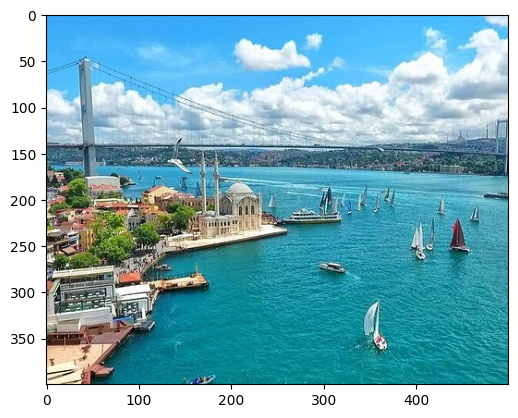

In [6]:
# Read the Istanbul image
image_url = "https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/Image_Segmentation/images/istanbul.jpg"
image_name = "istanbul.jpg"
image_ist = plt.imread(download_image(image_url, image_name))
print(image_ist.shape)
plt.imshow(image_ist)

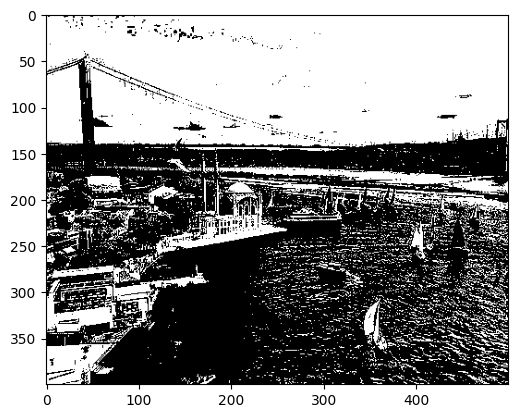

In [7]:
# Here the average value of the pixels is determined as threshold
gray_ist = rgb2gray(image_ist)

# Flatten the grayscale image for processing
gray_ist_reducted = gray_ist.reshape(-1)

for i in range(gray_ist_reducted.shape[0]):
    if gray_ist_reducted[i] > gray_ist_reducted.mean():
        gray_ist_reducted[i] = 1
    else:
        gray_ist_reducted[i] = 0

gray_ist = gray_ist_reducted.reshape(image_ist.shape[0],image_ist.shape[1])
plt.imshow(gray_ist, cmap='gray')

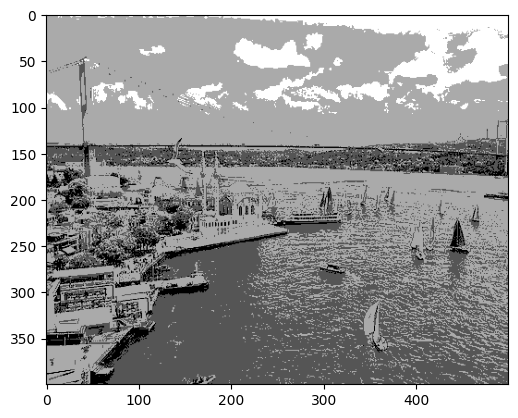

In [8]:
# Here we have three different thresholds. The values are average of the pixels, 0.5 and 0.25.
gray_ist = rgb2gray(image_ist)

# Flatten the grayscale image for processing
gray_ist_reducted = gray_ist.reshape(-1)

for i in range(gray_ist_reducted.shape[0]):
    if gray_ist_reducted[i] > gray_ist_reducted.mean():
        gray_ist_reducted[i] = 3
    elif gray_ist_reducted[i] > 0.5:
        gray_ist_reducted[i] = 2
    elif gray_ist_reducted[i] > 0.25:
        gray_ist_reducted[i] = 1
    else:
        gray_ist_reducted[i] = 0

gray_ist = gray_ist_reducted.reshape(image_ist.shape[0], image_ist.shape[1])
plt.imshow(gray_ist, cmap='gray')

### Edge Detection Segmentation

**Methodology:** Identifies the boundaries between objects in an image by detecting sharp changes in intensity. Algorithms like Sobel, Canny, and Prewitt are used to highlight edges. The segmentation is performed by outlining the shape of objects based on the detected edges.

**Use Cases:** Applications where the outline of objects is more important than their internal texture or color, such as identifying the shape of objects in an industrial inspection.

(1200, 1200, 3)


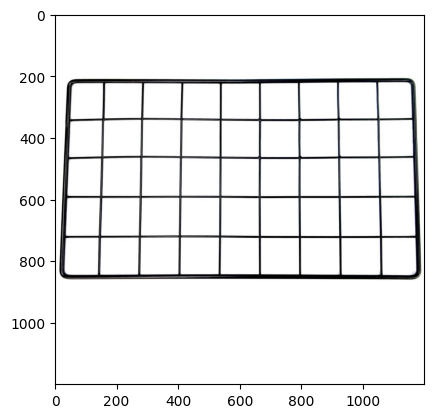

In [9]:
# Read the grid image
image_url = "https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/Image_Segmentation/images/grid.jpg"
image_name = "grid.jpg"
image_grid = plt.imread(download_image(image_url, image_name))
print(image_grid.shape)
plt.imshow(image_grid)

In [10]:
# Convert the image to the gray form
gray = rgb2gray(image_grid)

In [11]:
# Defining the sobel filters
sobel_horizontal = np.array([np.array([1, 2, 1]), np.array([0, 0, 0]), np.array([-1, -2, -1])])
print(sobel_horizontal, 'is a kernel for detecting horizontal edges')

sobel_vertical = np.array([np.array([-1, 0, 1]), np.array([-2, 0, 2]), np.array([-1, 0, 1])])
print(sobel_vertical, 'is a kernel for detecting vertical edges')

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]] is a kernel for detecting horizontal edges
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]] is a kernel for detecting vertical edges


In [12]:
# Convolve the image
out_h = ndimage.convolve(gray, sobel_horizontal, mode='reflect')
out_v = ndimage.convolve(gray, sobel_vertical, mode='reflect')
# here mode determines how the input array is extended when the filter overlaps a border.

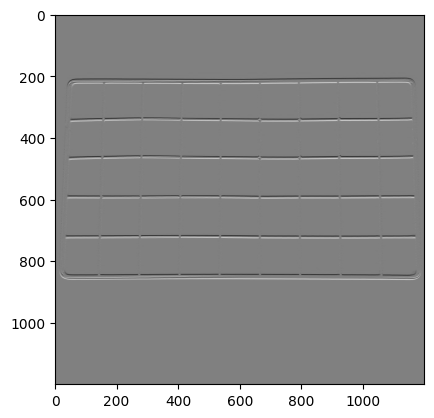

In [13]:
# Show the horizontal edges
plt.imshow(out_h, cmap='gray')

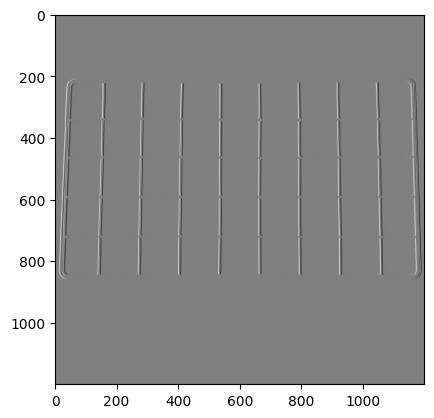

In [14]:
# Show the vertical edges
plt.imshow(out_v, cmap='gray')

In [15]:
# Defining the laplace filters. It shows both vertical and horizantal edges.
kernel_laplace = np.array([np.array([1, 1, 1]), np.array([1, -7, 1]), np.array([1, 1, 1])])
print(kernel_laplace, 'is a laplacian kernel')

[[ 1  1  1]
 [ 1 -7  1]
 [ 1  1  1]] is a laplacian kernel


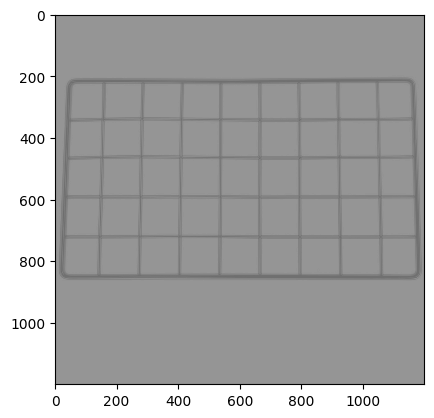

In [16]:
# Convolve the image with the laplace filter and show the edges.
out_l = ndimage.convolve(gray, kernel_laplace, mode='reflect')
plt.imshow(out_l, cmap='gray')

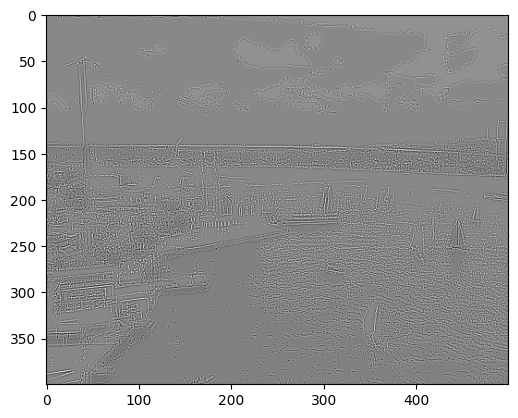

In [17]:
# Apply the laplace filter to the Istanbul image.
out_l_ist = ndimage.convolve(gray_ist, kernel_laplace, mode='reflect')
plt.imshow(out_l_ist, cmap='gray')

### Clustering Techniques

**Methodology:** Groups pixels into clusters based on their feature similarities, such as color or texture. K-means and Mean Shift are common clustering algorithms used for segmentation. The algorithm treats each pixel as a point in a feature space and partitions the image into clusters based on the proximity of these feature points.

**Use Cases:** Segmenting natural scenes where objects can be distinguished based on color or texture patterns, like segmenting different terrain types in satellite images.

(200000, 3)

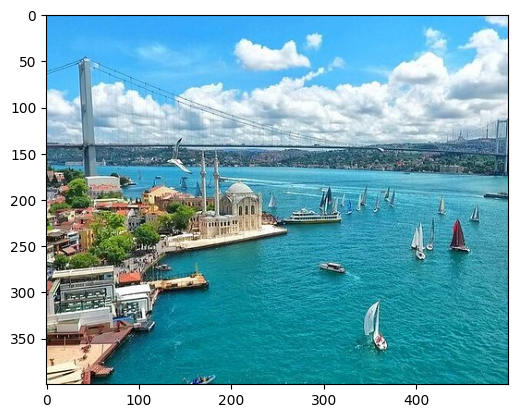

In [18]:
pic_cluster = image_ist/255  # dividing by 255 to bring the pixel values between 0 and 1
plt.imshow(pic_cluster)
pic_n = pic_cluster.reshape(pic_cluster.shape[0] * pic_cluster.shape[1], pic_cluster.shape[2])
pic_n.shape

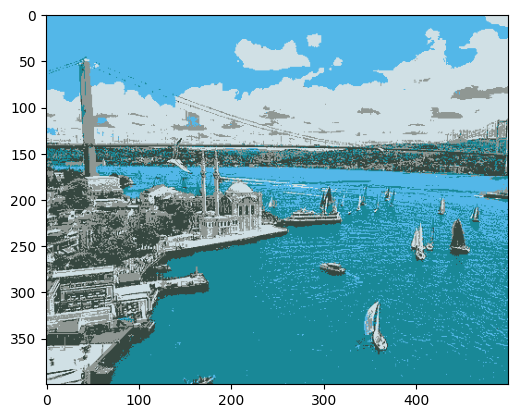

In [19]:
# Create 5 clusters of the pixels
kmeans = KMeans(n_clusters=5, random_state=0, n_init='auto').fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(pic_cluster.shape[0], pic_cluster.shape[1], pic_cluster.shape[2])
plt.imshow(cluster_pic)

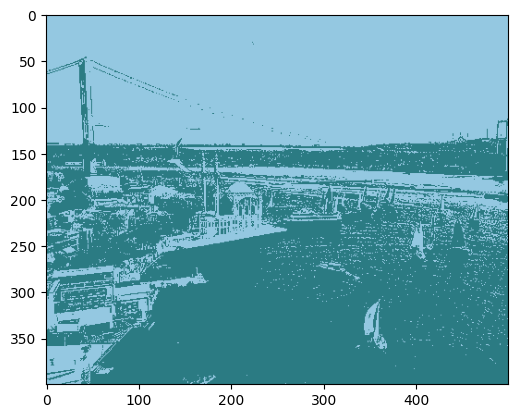

In [20]:
# Create 2 clusters of the pixels
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(pic_cluster.shape[0], pic_cluster.shape[1], pic_cluster.shape[2])
plt.imshow(cluster_pic)

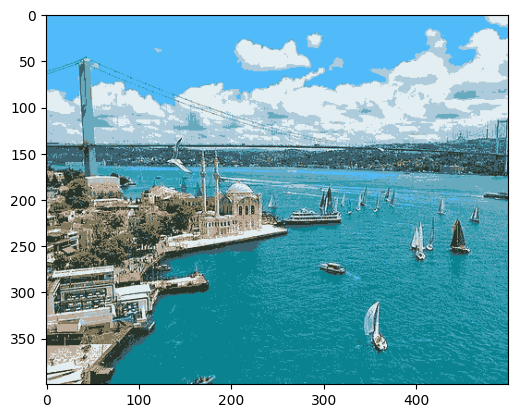

In [21]:
# Create 10 clusters of the pixels
kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto').fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(pic_cluster.shape[0], pic_cluster.shape[1], pic_cluster.shape[2])
plt.imshow(cluster_pic)

### Depp-Learning Based Methods

**Methodology:** Utilizes convolutional neural networks (CNNs) to perform segmentation at a pixel level. Architectures like U-Net, SegNet, and DeepLab are trained on large datasets to learn complex features for accurate segmentation. These models often employ an encoder-decoder structure to capture both high-level semantic and low-level spatial information.

**Use Cases:** Advanced applications requiring high precision and context understanding, such as autonomous driving, detailed land use and land cover mapping, and precise medical diagnostic

## Leveraging Deep Learning for Enhanced Image Segmentation


Deep learning has significantly transformed the landscape of image segmentation by introducing models that are capable of learning complex patterns and features directly from data. This has led to substantial improvements in accuracy, efficiency, and the ability to handle a wide range of segmentation tasks across different domains. Here are some prominent deep learning models used in the image segmentation:

### U-Net Architecture

The U-Net architecture is a convolutional neural network (CNN) developed specifically for biomedical image segmentation, introduced by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in their 2015 paper titled "U-Net: Convolutional Networks for Biomedical Image Segmentation."

Its design and effectiveness have made it a widely adopted model for various image segmentation tasks beyond biomedical imaging. The architecture is named "U-Net" because its structure resembles the letter "U."

**Key Features of U-Net:**

- Symmetric Structure: The U-Net architecture is characterized by its symmetric shape, which includes a contracting path (encoder) to capture context and a symmetric expanding path (decoder) to enable precise localization.

- Contracting Path (Encoder) and Expanding Path (Decoder): The encoder consists of repeated convolutions (each followed by a rectified linear unit (ReLU) activation). The decoder includes a series of up-convolutions and concatenations with the corresponding feature map from the encoder (skip connections).

- Skip Connections: These connections provide the expanding path with information from the contracting path, helping the network localize and refine segmentation boundaries by combining low-level feature maps with higher-level ones.

- Final Layer: A 1x1 convolution is used at the final layer to map each feature vector to the desired number of classes.

### Mask R-CNN

Mask R-CNN (Region-based Convolutional Neural Network) is an extension of the Faster R-CNN, a popular object detection framework. Introduced by He et al. in their 2017 paper, Mask R-CNN is designed to efficiently perform instance segmentation, which involves identifying individual objects within an image and delineating their boundaries with high precision. It does so by not only predicting the class and bounding box for each object but also generating a binary mask that specifies the shape of the object at the pixel level. Here's how Mask R-CNN functions and what makes it particularly suitable for instance segmentation:

Functioning of Mask R-CNN:

- Backbone Network: Mask R-CNN utilizes a convolutional neural network (CNN) backbone, such as ResNet, for feature extraction. This backbone processes the input image to produce a high-dimensional feature map.
- Region Proposal Network (RPN): Over the feature map, an RPN is used to identify object proposals. The RPN scans the feature map with anchor boxes at different scales and aspect ratios, predicting the likelihood of an anchor being an object and proposing bounding boxes around potential objects.
- RoI (Region of Interest) Align: For each proposed bounding box from the RPN, RoI Align extracts a fixed-size feature map (e.g., 7x7). Unlike its predecessor, RoI Pooling, which may introduce quantization errors, RoI Align uses bilinear interpolation to preserve precise spatial locations, crucial for accurate mask prediction.
- Branches for Classification, Bounding Box Regression, and Mask Prediction: For each RoI, Mask R-CNN simultaneously predicts the object class, refines the bounding box, and generates a binary mask. Notably, the mask branch is a small fully convolutional network (FCN) applied to each RoI, predicting a segmentation mask in a pixel-to-pixel manner. This branch operates independently for each class, avoiding competition among classes for mask generation.

### DeepLab Versions

DeepLab is a series of highly influential semantic segmentation models developed by researchers at Google. These models have significantly advanced the state-of-the-art in semantic segmentation by introducing several key innovations, particularly in handling varying scales and improving boundary localization in images. Here's an overview of the different versions of DeepLab and their contributions to the development of image segmentation:

#### DeepLabV1

- Introduced: Atrous Convolution (also known as dilated convolution).

- Contribution: DeepLabV1 utilized atrous convolution to explicitly control the resolution at which feature responses are computed within Deep Convolutional Neural Networks. This innovation allowed the model to capture multi-scale information and effectively enlarge the field of view of filters to incorporate larger context without increasing the number of parameters or the amount of computation. It was particularly useful for segmenting objects at multiple scales within an image.

#### DeepLabV2

- Introduced: Atrous Spatial Pyramid Pooling (ASPP).
- Contribution: DeepLabV2 extended the use of atrous convolution by implementing ASPP, which probes an incoming convolutional feature layer with filters at multiple sampling rates and effective field-of-views, capturing objects as well as image context at multiple scales. This approach significantly improved segmentation accuracy, especially along object boundaries and in capturing fine details.

#### DeepLabV3

- Introduced: Improvements to Atrous Spatial Pyramid Pooling.
- Contribution: DeepLabV3 further refined the ASPP module by including batch normalization and image-level feature to the ASPP. This version focused on optimizing the performance of ASPP for more robust multi-scale context extraction without the need for CRFs (Conditional Random Fields) which were used in previous versions to refine the segmentation results.

#### DeepLabV3+

- Introduced: Encoder-Decoder Structure.
- Contribution: DeepLabV3+ added a decoder module to the ASPP-equipped encoder network to refine the segmentation results further, especially at object boundaries. The encoder-decoder structure improved the sharpness of the segmentation maps and the overall accuracy. The addition of the decoder helped in refining the segmentations by utilizing both low-level feature information for boundary detail and high-level features for semantic context, making DeepLabV3+ highly effective for a wide range of segmentation tasks.


#### Contributions to Image Segmentation



- Scale Invariance: DeepLab models addressed the challenge of segmenting objects at various scales by using atrous convolution and ASPP, allowing for effective segmentation of both small and large objects within the same framework.
- Boundary Precision: The incorporation of encoder-decoder structures in DeepLabV3+ and the refinement through ASPP enabled precise segmentation of object boundaries, a critical aspect for many applications of semantic segmentation.
- Efficiency and Performance: DeepLab models demonstrated that high segmentation accuracy could be achieved without excessively increasing computational cost, making them suitable for practical applications.

Overall, the DeepLab series has significantly influenced semantic segmentation research and applications, introducing techniques that have become standard components in many subsequent segmentation models. Their advancements in handling scale variation and improving boundary localization have helped push the boundaries of what is achievable in semantic segmentation

### Meta's Segment Anything Model (SAM)

The Segment Anything Model (SAM) is an advanced AI model developed by Meta AI designed to perform image segmentation tasks. It stands out due to its promptable segmentation capabilities, meaning it can generate valid segmentation masks from given prompts, such as spatial or text clues identifying an object. SAM's architecture includes a powerful image encoder, a prompt encoder, and a lightweight mask decoder, allowing it to process segmentation tasks with flexibility, real-time mask computation, and awareness of ambiguities​​.

SAM is notable for its zero-shot performance, trained on the expansive SA-1B dataset, which features over 1 billion masks spread over 11 million curated images. This vast training allows SAM to adapt to new image distributions and tasks without prior knowledge, showcasing impressive zero-shot performance across various segmentation tasks​​.

For non-experts, SAM democratizes image segmentation by enabling fully automatic recognition and detection of objects in images without the need for additional training. This capability makes it particularly suitable for a wide range of applications, from AI-assisted labeling to healthcare and land cover mapping. SAM’s versatility and efficiency in adapting to new segmentation challenges are enhanced by its foundation on transfer learning and pre-trained models like ResNet, VGG, and EfficientNet​​.

SAM’s impact is further amplified by the SA-1B Dataset, the most extensive and diverse image segmentation dataset available, containing over 1 billion high-quality segmentation masks derived from a vast array of images covering a broad spectrum of scenarios, objects, and environments. This dataset enables more robust training, allowing models like SAM to handle an unprecedented range of image segmentation tasks with high accuracy​​.

In essence, SAM revolutionizes image segmentation, making it accessible and adaptable for a wide array of tasks without the need for specialized knowledge in AI or machine learning, thus broadening the possibilities for application in various industries and research fields. For more detailed information on SAM and its applications, you can visit the [Segment Anything](https://segment-anything.com/).

## Applications of Image Segmentation

* Medical Imaging
* Video Surveillance
* Autonomous Vehicles
* Agriculture
* Satellite Imagery
* Robotics
* Art and Design
* Gaming
* Fashion and Retail

## Evaluation

### Intersection Over Union (IOU)

IOU, short for Intersection Over Union, is a pivotal metric for evaluating the performance of image segmentation models. It measures the accuracy of an object detector on a particular dataset, determining how well the predicted segmentation masks overlap with the ground truth masks. IOU is particularly important in the fields of computer vision and image processing because it provides a straightforward and intuitive way to quantify the precision of segmentation results.

#### How IOU is Calculated:

IOU is calculated as the ratio of the area of overlap between the predicted segmentation and the ground truth to the area of the union of the predicted and ground truth segmentations. Mathematically, it can be expressed as:

$$
\text{IOU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
$$

To compute it:
1. **Intersection (Area of Overlap)**: Identify all the pixels that are classified as part of the object of interest in both the predicted segmentation and the ground truth.
2. **Union (Area of Union)**: Identify all the pixels that are classified as part of the object in either the predicted segmentation or the ground truth.
3. **Calculate the Ratio**: Divide the number of pixels in the intersection by the number of pixels in the union.

In [22]:
def calculate_iou(pred_mask, true_mask):
    """
    Calculate Intersection Over Union (IOU) for binary masks.

    Parameters:
    pred_mask (numpy.ndarray): Predicted binary segmentation mask.
    true_mask (numpy.ndarray): Ground truth binary segmentation mask.

    Returns:
    float: IOU score.
    """
    # Ensure boolean for calculations
    pred_mask_bool = pred_mask.astype(np.bool_)
    true_mask_bool = true_mask.astype(np.bool_)

    # Intersection: Element-wise logical AND
    intersection = np.logical_and(pred_mask_bool, true_mask_bool).sum()

    # Union: Element-wise logical OR
    union = np.logical_or(pred_mask_bool, true_mask_bool).sum()

    # Avoid division by zero
    if union == 0:
        return 0

    # IOU calculation
    iou_score = intersection / union
    return iou_score


# Example masks
pred_mask = np.array([[1, 1, 0, 0],
                      [1, 1, 0, 0],
                      [0, 0, 1, 1],
                      [0, 0, 1, 1]])
true_mask = np.array([[1, 0, 0, 0],
                      [1, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 1, 1]])

iou_score = calculate_iou(pred_mask, true_mask)
print(f"IOU Score: {iou_score}")


IOU Score: 0.75


#### Importance of IOU in Image Segmentation:

- **Accuracy Measurement**: IOU provides a clear measure of how accurately the model segments images, making it essential for comparing the performance of different segmentation models.
- **Balance Between Precision and Recall**: By considering both the area of overlap and the area of union, IOU inherently balances precision (how many of the predicted pixels are relevant) and recall (how many of the relevant pixels are predicted correctly).
- **Applicability Across Datasets**: IOU can be applied universally across different datasets and tasks, making it a standard metric for evaluating segmentation models.
- **Threshold Flexibility**: The metric can be thresholded to define what constitutes a successful prediction, allowing researchers and practitioners to adjust the evaluation criteria based on the specific requirements of their application.

Given its direct approach to measuring the similarity between the predicted segmentation and the ground truth, IOU is indispensable for developing and benchmarking image segmentation models. It helps in identifying areas where a model might need improvement, such as under-segmentation or over-segmentation, guiding the refinement of algorithms for better performance.

For more detailed evaluations, sometimes variations of IOU, like mean IOU (mIOU) across different classes or thresholds, are used to gain insights into model performance across diverse scenarios and object types.

# Implementing U-Net for Image Segmentation

## Preparing the Dataset

#### Download the dataset

Dataset download procedure:
1. `Download` the dataset from [Kaggle](https://www.kaggle.com/datasets/wenewone/cub2002011)
2. `Unzip` it (and the directories it contains) into the dataset root directory.
3. `Rename` the top-level directory `cub_200`
4. `Download` the [test_train_split.txt](https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/Image_Segmentation/data/test_train_split.txt) file.


In [23]:
# Dataset root
data_set_root = "./datasets"

# What to resize our images to
image_size = 128

# Batch size
batch_size = 64

In [24]:
# Ensure kaggle is installed (Uncomment the next line if Kaggle is not installed)
# !pip install kaggle

In [ ]:
# Input Kaggle credentials
kaggle_username = input("Enter your Kaggle username: ")
kaggle_key = input("Enter your Kaggle key: ")

# Set environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

In [26]:
# Download the dataset from Kaggle
!kaggle datasets download wenewone/cub2002011 -p ./datasets

 99%|█████████████████████████████████████▊| 1.49G/1.49G [00:21<00:00, 93.9MB/s]
100%|██████████████████████████████████████| 1.49G/1.49G [00:21<00:00, 75.3MB/s]


In [27]:
# Unzip the dataset and its directories into the datasets directory, then remove the zip file
!unzip -q ./datasets/cub2002011.zip -d ./datasets && rm ./datasets/cub2002011.zip

In [28]:
# Download the test_train_split.txt file
!wget https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/Image_Segmentation/data/test_train_split.txt

--2024-03-13 20:07:29--  https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/Image_Segmentation/data/test_train_split.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83198 (81K) [text/plain]
Saving to: 'test_train_split.txt'

test_train_split.tx 100%[===================>]  81.25K  --.-KB/s    in 0.02s   

2024-03-13 20:07:30 (4.89 MB/s) - 'test_train_split.txt' saved [83198/83198]



#### Define the Dataset Class

In [29]:
class CUB200Dataset(Dataset):
    def __init__(self, dataset_root, image_size, transform, is_train=True):
        self.dataset_root = Path(dataset_root)
        self.image_size = image_size
        self.transform = transform
        self.is_train = is_train

        self.image_root_dir = self.dataset_root / "CUB_200_2011" / "images"
        self.mask_root_dir = self.dataset_root / "segmentations"

        self.data_df = self._prepare_dataframe()

    def _prepare_dataframe(self):
        # Simplified dataframe preparation, focusing on essentials
        images_df = pd.read_csv(self.dataset_root / "CUB_200_2011" / "images.txt", sep=" ", names=["index", "file_path"])
        split_df = pd.read_csv("test_train_split.txt", sep=" ", names=["index", "is_train"])

        # Filter based on training or testing split
        merged_df = pd.merge(images_df, split_df, on="index")
        filtered_df = merged_df[merged_df["is_train"] == (1 if self.is_train else 0)]

        return filtered_df

    def __getitem__(self, index):
        data_row = self.data_df.iloc[index]
        img_path = self.image_root_dir / data_row["file_path"]
        image = cv2.imread(str(img_path))
        if image is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_path = self.mask_root_dir / data_row["file_path"].replace(".jpg", ".png")
        mask = cv2.imread(str(mask_path))
        if mask is None:
            raise FileNotFoundError(f"Mask not found at {mask_path}")

        if not self.transform:
            raise RuntimeError("Transform not defined")

        transformed = self.transform(image=image, mask=mask)
        transformed['mask'] = (transformed["mask"][:, :, 0] > 100).long()
        image, mask = transformed['image'], transformed['mask']

        return image, mask


    def __len__(self):
        return len(self.data_df)

#### Transforms

In [30]:
train_transform = A.Compose([A.HorizontalFlip(p=0.1),
                             A.Resize(image_size, image_size),
                             A.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
                            ToTensorV2()])

test_transform = A.Compose([A.Resize(image_size, image_size),
                           A.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225]),
                            ToTensorV2()])

#### Prepare the Loader

In [31]:
# Initialize the dataset objects for training and testing
train_data = CUB200Dataset(dataset_root=data_set_root, image_size=image_size, transform=train_transform, is_train=True)

test_data = CUB200Dataset(dataset_root=data_set_root, image_size=image_size, transform=test_transform, is_train=False)

# Split training data into train and validation sets with 90/10% training/validation split
validation_split = 0.9

n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

# To perform the split, since `random_split` returns subsets of the original dataset,
# we need to wrap the `CUB200Dataset` in a `Subset` if we intend to modify it afterward.
# Here, however, we are directly splitting it, which is also fine as long as we don't need to modify the dataset further.
train_subset, valid_subset = random_split(train_data, [n_train_examples, n_valid_examples],
                                      generator=torch.Generator().manual_seed(42))


# Create data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Training data size: {len(train_subset)}")
print(f"Validation data size: {len(valid_subset)}")
print(f"Test data size: {len(test_data)}")

Training data size: 7376
Validation data size: 820
Test data size: 3592


#### Show Data

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_image_mask(images, masks, num_samples=4):
    """
    Visualizes images and their corresponding masks side-by-side.

    Parameters:
    - images: a batch of images from the DataLoader.
    - masks: a batch of masks corresponding to the images.
    - num_samples: the number of samples to visualize. Default is 4.
    """
    # Ensure we don't try to display more images than we have in the batch
    num_samples = min(num_samples, images.size(0))

    fig, axs = plt.subplots(nrows=num_samples, ncols=2, figsize=(10, num_samples * 5))

    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()  # Convert from PyTorch tensor to numpy array and adjust channel order
        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1

        mask = masks[i].numpy()  # Convert mask to numpy array

        axs[i, 0].imshow(img)
        axs[i, 1].imshow(mask, cmap='gray')  # Display the mask in grayscale

        axs[i, 0].set_title('Image')
        axs[i, 1].set_title('Mask')

        # Hide axis ticks
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

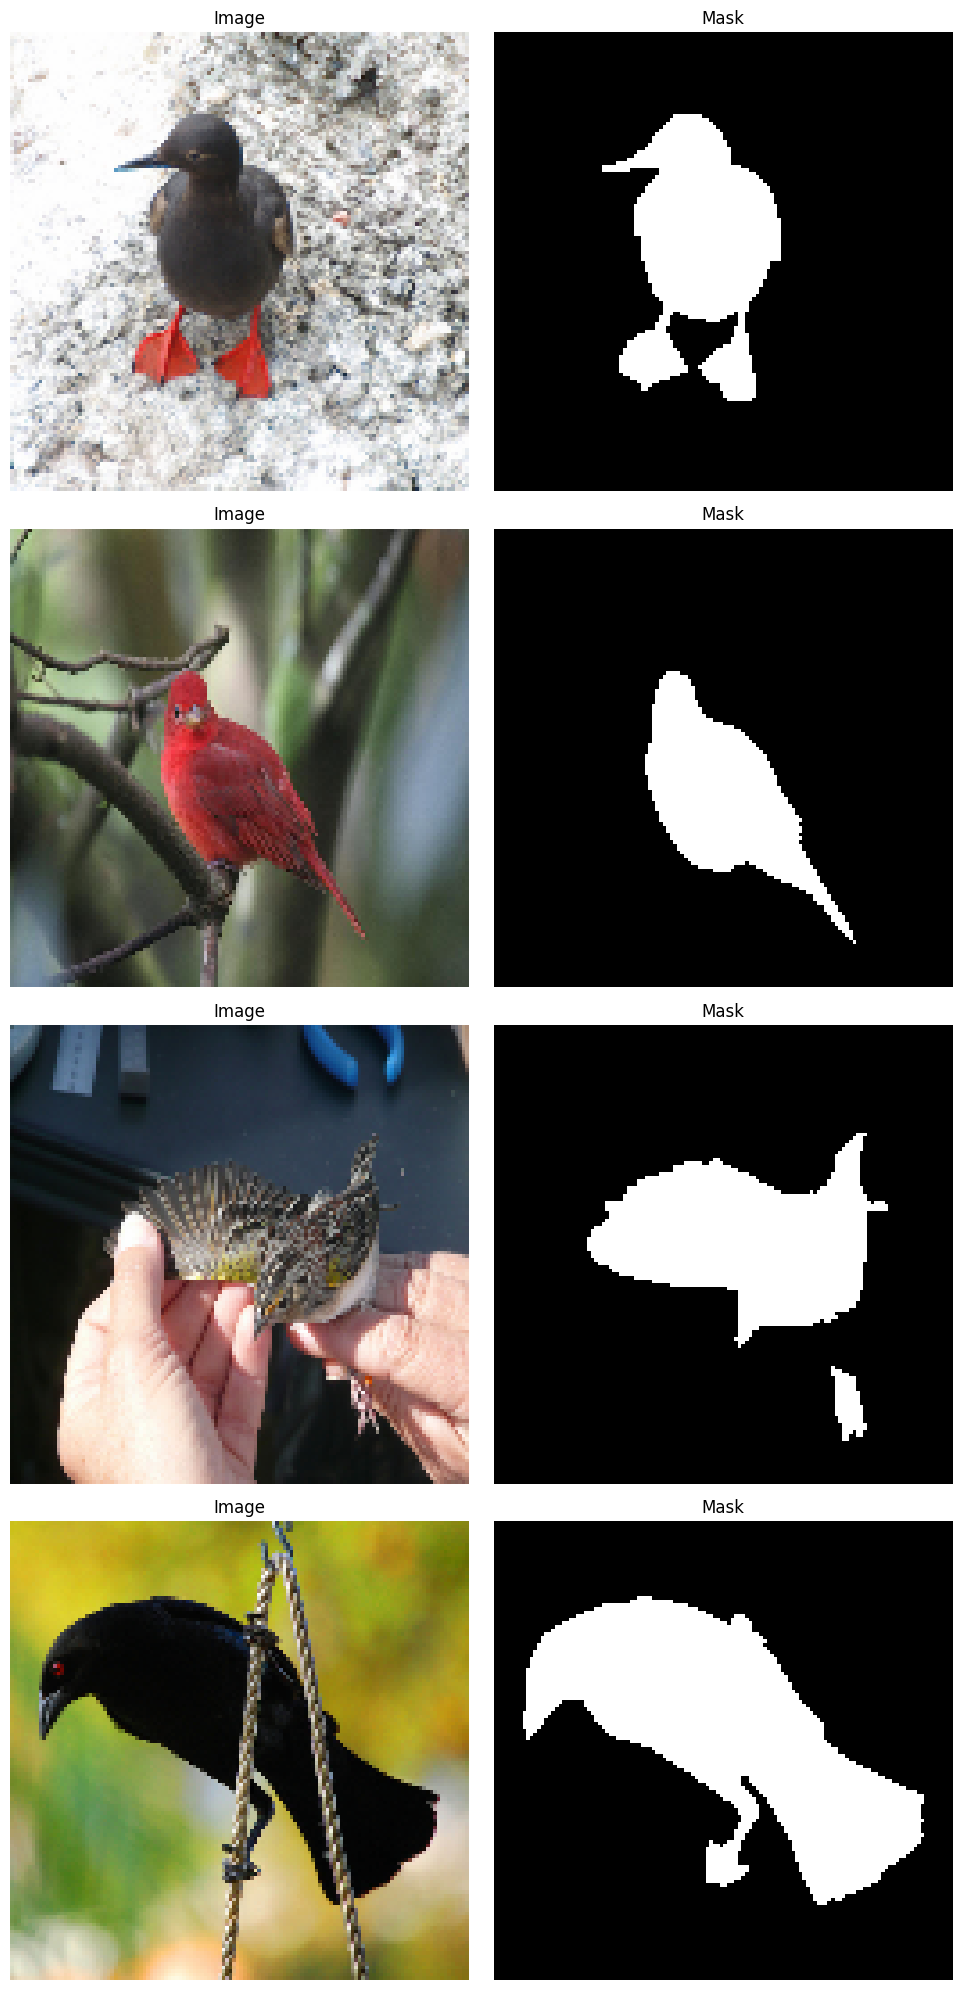

In [33]:
# Visualize original images and masks
for images, masks in train_loader:
    visualize_image_mask(images, masks, num_samples=4)
    break  # Only visualize the first batch

## Model Architecture

#### General Architecture

Original paper by Olaf Ronneberger, Philipp Fischer, Thomas Brox:

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

![U-net Architecture](https://raw.githubusercontents.com/arkeodev/computer-vision/main/Image_Segmentation/images/unet.png)



Now let's break down model into components and implement each of them separately

#### Double Convolution Blocks

In [34]:
class DoubleConv(nn.Module):
    """Performs two sequences of convolution, batch normalization, and ReLU activation.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
    """
    def __init__(self, in_ch: int, out_ch: int):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

Separating the DoubleConv block as a distinct component brings ***Modularity*** and ***Ease of Modification***

Here are the different components of the double convolution block:

Feature Extraction and Non-linearity: The DoubleConv block performs two sequences of convolution, batch normalization, and ReLU activation. This combination is pivotal for effective feature extraction in CNNs. T

Convolution: The use of nn.Conv2d with kernel size 3 and padding 1 ensures that the spatial dimensions of the input are preserved after the convolution, assuming the stride is set to 1 (the default). This is crucial for maintaining the resolution of feature maps throughout the network.

Batch Normalization: Following each convolution, nn.BatchNorm2d normalizes the output, which can lead to faster convergence and overall improved training stability by reducing internal covariate shift.

ReLU Activation: The nn.ReLU(inplace=True) activation function introduces non-linearity, allowing the network to capture complex patterns in the data. The inplace=True argument is used to reduce memory usage by modifying the input directly without allocating additional output memory.

#### Downsampling

In [35]:
class Down(nn.Module):
    """Downsampling followed by DoubleConv block.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
    """
    def __init__(self, in_ch: int, out_ch: int):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mpconv(x)

**Feature Reduction and Complexity Management:**

The primary purpose of the Down class is to reduce the spatial dimensions of the feature maps as the input data progresses deeper into the network. This downsampling process helps in managing the computational complexity and memory usage.

By following the downsampling operation with a DoubleConv block, the Down class ensures that the network continues to refine and extract higher-level features from the input data, even as the resolution of the feature maps decreases.

#### Upsampling

In [36]:
class Up(nn.Module):
    """Upsampling followed by a DoubleConv block. Supports bilinear upsampling or transposed convolution.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
        bilinear (bool): If True, uses bilinear upsampling. Otherwise, uses transposed convolution.
    """
    def __init__(self, in_ch: int, out_ch: int, bilinear: bool = True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

##### Bilinear vs. Transposed Convolution



```
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
```




The `Up` class in the U-Net architecture is designed for the expansive path, where the goal is to progressively increase the spatial dimensions of the feature maps to reconstruct the original image size with the desired segmentation map. This class incorporates several key elements to achieve this goal:



Bilinear Upsampling (nn.Upsample): When bilinear=True, this method is used for upsampling, which involves ***linear interpolation*** to increase the size of the input feature map by a scale factor of 2. Bilinear upsampling is ***non-learnable*** and focuses on ***smoothly enlarging*** the feature map while minimizing the introduction of artifacts.


Transposed Convolution (nn.ConvTranspose2d): If bilinear=False, transposed convolution is employed. This learnable upsampling method uses parameters that are learned during training to perform the upsampling, which can help in creating more detailed reconstructions by learning the optimal way to increase the spatial dimensions. The operation is defined with a kernel size of 2 and a stride of 2, effectively doubling the dimensions of the input feature map.

Choosing between bilinear upsampling and transposed convolution allows for flexibility in how the network learns to upsample, balancing between smoothness (bilinear) and detail (transposed convolution).

In [37]:
# Define a simple 2x2 input
input_tensor = torch.tensor([[[[1.0, 2.0], [3.0, 4.0]]]], dtype=torch.float32)

# Bilinear Upsampling
upsampled_bilinear = F.interpolate(input_tensor, scale_factor=2, mode='bilinear', align_corners=True)

# Transposed Convolution
# Creating a transposed convolution layer manually requires setting up a ConvTranspose2d layer.
# For simplicity, we'll use a predefined one with a kernel size of 2, stride of 2, and no learning (fixed weights).
# Normally, the weights are learned, but here we'll just set them to perform a simple nearest neighbor "upsample" for demonstration.
transposed_conv = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=2, bias=False)
transposed_conv.weight.data = torch.tensor([[[[1.0, 1.0], [1.0, 1.0]]]], dtype=torch.float32)  # simple bilinear-like kernel

# Apply transposed convolution
upsampled_transposed_conv = transposed_conv(input_tensor)

print(f"Bilinear Upsampling: {upsampled_bilinear}\n")
print(f"Transposed Convolution: {upsampled_transposed_conv}")

Bilinear Upsampling: tensor([[[[1.0000, 1.3333, 1.6667, 2.0000],
          [1.6667, 2.0000, 2.3333, 2.6667],
          [2.3333, 2.6667, 3.0000, 3.3333],
          [3.0000, 3.3333, 3.6667, 4.0000]]]])

Transposed Convolution: tensor([[[[1., 1., 2., 2.],
          [1., 1., 2., 2.],
          [3., 3., 4., 4.],
          [3., 3., 4., 4.]]]], grad_fn=<ConvolutionBackward0>)


##### Handling Spatial Dimension Mismatch



```
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
```



Before concatenating the upsampled feature map with the feature map from the downsampling path (skip connections), it's essential to ensure they have the same dimensions. The spatial dimensions may not always perfectly align due to the rounding operations in downsampling and upsampling processes. To address this:

* Calculate Dimension Differences: The differences in dimensions between `x2` (feature map from the downsampling path) and `x1` (upsampled feature map) are calculated using `diffY` and `diffX`.

* Padding: To reconcile these differences, `x1` is padded using `F.pad`, ensuring that its dimensions match those of `x2` before concatenation. The padding is evenly distributed as much as possible (with any extra padding added to the right or bottom side), making the feature maps compatible for concatenation.

This handling of spatial dimension mismatch is crucial for maintaining the integrity of the feature maps and ensuring that the skip connections effectively contribute to the final segmentation accuracy.

It can be seen a very simple implementation of the code snippet to show how it works:

In [38]:
# Define two simple tensors to simulate the feature maps before and after upsampling
# Simulate x2 (feature map from downsampling path) as a 4x4 tensor
x2 = torch.tensor([[[[1.0, 2.0, 3.0, 4.0],
                     [5.0, 6.0, 7.0, 8.0],
                     [9.0, 10.0, 11.0, 12.0],
                     [13.0, 14.0, 15.0, 16.0]]]])

# Simulate x1 (upsampled feature map) as a 3x3 tensor to introduce a size mismatch
x1 = torch.tensor([[[[1.0, 2.0, 3.0],
                     [4.0, 5.0, 6.0],
                     [7.0, 8.0, 9.0]]]])

# Calculate the size difference
diffY = x2.size()[2] - x1.size()[2]
print(f"diffY: {diffY}\n")
diffX = x2.size()[3] - x1.size()[3]
print(f"diffX: {diffX}\n")

# Apply padding to make x1's size match x2's size
x1_padded = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
print(f"x1_padded: {x1_padded}\n")

# Concatenate the feature maps along the channel dimension
x_combined = torch.cat([x2, x1_padded], dim=1)
print(f"x_combined: {x_combined}\n")


diffY: 1

diffX: 1

x1_padded: tensor([[[[1., 2., 3., 0.],
          [4., 5., 6., 0.],
          [7., 8., 9., 0.],
          [0., 0., 0., 0.]]]])

x_combined: tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]],

         [[ 1.,  2.,  3.,  0.],
          [ 4.,  5.,  6.,  0.],
          [ 7.,  8.,  9.,  0.],
          [ 0.,  0.,  0.,  0.]]]])



##### Skip Connections

The operation `x = torch.cat([x2, x1], dim=1)` utilizes skip connections, a critical component of the U-Net architecture. These connections concatenate the feature maps from the corresponding downsampling layer `(x2)` with the upsampled feature maps `(x1)`. This process ensures that the network can use both the high-level, abstract features learned deep in the network and the more detailed, spatial information available in the shallower layers. This combination is essential for accurate pixel-wise segmentation as it helps the network better localize the segmentation boundaries.

#### U-Net Class

In [39]:
# 2D-Unet Model taken from https://github.com/black0017/MedicalZooPytorch/blob/master/lib/medzoo/Unet2D.py

class InConv(nn.Module):
    """Initial convolution block that uses DoubleConv to process the input.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
    """
    def __init__(self, in_ch: int, out_ch: int):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

class OutConv(nn.Module):
    """Final convolutional layer that maps the feature map to the desired number of classes.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
    """
    def __init__(self, in_ch: int, out_ch: int):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

class Unet(nn.Module):
    """U-Net architecture for semantic segmentation.

    Args:
        in_channels (int): Number of input channels.
        classes (int): Number of output classes.
    """
    def __init__(self, in_channels: int, classes: int):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes = classes
        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

    def test(self, device='cuda') -> None:
        """Performs a test run with a dummy input to check the model architecture."""
        device = torch.device(device)
        input_tensor = torch.rand(1, 3, 128, 128).to(device)
        ideal_out = torch.rand(1, 2, 128, 128).to(device)  # Assuming 2 classes for the output
        out = self.forward(input_tensor)
        assert ideal_out.shape == out.shape, f"Output shape is {out.shape}, but expected {ideal_out.shape}"
        print("Output shape:", out.shape)
        print("Unet test is complete")


In [40]:
# Instantiate and test the U-Net model
unet_model = Unet(in_channels=3, classes=2).to(device)
unet_model.test(device=device)

Output shape: torch.Size([1, 2, 128, 128])
Unet test is complete


## Training and Evaluating the U-Net Model

### Parameters

In [51]:
# Create our network
unet_model = Unet(in_channels=3, classes=2).to(device)

# Learning rate
learning_rate = 1e-4

# Image segmentation Loss
loss_function = nn.CrossEntropyLoss()

# Number of epochs
num_epochs = 25

# Model saving directory
save_dir = './models'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# Model Name
model_name = 'UNet_Image_Seg'

# Starting Epoch Number
start_epoch = 0

# Checkpoint starting option
start_from_checkpoint = False

# Best validation accuracy initialisation
best_valid_acc = 0

# Placeholder for logging
train_loss_logger = []
train_acc_logger = []
val_acc_logger = []

### Optimizers

In [52]:
# Setup optimizer
optimizer = optim.Adam(unet_model.parameters(), lr=learning_rate)

### Learning Rate Schedulere

In [53]:
lr_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

### Checkpoint Management

In [54]:
def load_checkpoint(save_path):
    # Check if checkpoint exists
    if os.path.isfile(save_path):
        # Load Checkpoint
        check_point = torch.load(save_path)

        # Checkpoint is saved as a python dictionary
        # Here we unpack the dictionary to get our previous training states
        unet_model.load_state_dict(check_point['model_state_dict'])
        optimizer.load_state_dict(check_point['optimizer_state_dict'])

        start_epoch = check_point['epoch']
        best_valid_acc = check_point['best_valid_acc']

        train_loss_logger = check_point['train_loss_logger']
        train_acc_logger = check_point['train_acc_logger']
        val_acc_logger = check_point['val_acc_logger']

        print("Checkpoint loaded, starting from epoch:", start_epoch)
    else:
        # Raise Error if it does not exist
        raise ValueError("Checkpoint Does not exist")

def save_checkpoint(epoch, valid_acc):
    best_valid_acc = valid_acc
    save_path = os.path.join(save_dir, model_name + ".pt")

    torch.save({
        'epoch': epoch,
        'model_state_dict': unet_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_valid_acc': valid_acc,
        'train_loss_logger': train_loss_logger,
        'train_acc_logger': train_acc_logger,
        'val_acc_logger': val_acc_logger,
    }, save_path)

### Train Function

In [55]:
scaler = torch.cuda.amp.GradScaler()

def train_model():
    if train_loader is None:
        ValueError("Dataset not defined!")

    # Set Network in train mode
    unet_model.train()
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):
        inputs, targets = data[0].to(device), data[1].to(device)

        with torch.cuda.amp.autocast():
            # Forward pass of image through network and get output
            outputs = unet_model(inputs)

            # Calculate loss using loss function
            loss = loss_function(outputs, targets)

        # Zero gradients
        optimizer.zero_grad()

        # Backpropagate gradients
        scaler.scale(loss).backward()

        # Clip grads
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(unet_model.parameters(), 5)

        # Do a single optimization step
        scaler.step(optimizer)
        scaler.update()

        # Log the loss for plotting
        train_loss_logger.append(loss.item())


### Evaluating the Model

In [56]:
# nn.Module class that will return the IoU for a batch of outputs
class MaskIOU(nn.Module):

    def mask_intersection_over_union(self, pred_bbox, target_bbox):

        # compute the area of intersection rectangle
        interArea = (pred_bbox * target_bbox).sum(dim=[1, 2])

        area1 = pred_bbox.sum(dim=[1, 2])
        area2 = target_bbox.sum(dim=[1, 2])

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / (area1 + area2 - interArea + 1e-5)

        # return the intersection over union value
        return iou

    def forward(self, predictions, data):
        """
        data: list of data, index 0 is the input image index [0] is the target
        predictions: raw output of the model
        """

        pred_mask = predictions.argmax(1)
        target_mask = data[1].to(pred_mask.device)

        return self.mask_intersection_over_union(pred_mask, target_mask)

In [57]:
# Evaluation metric is IOU
eval_metric = MaskIOU()

In [58]:
def evaluate_model(train_test_val="test"):
    if test_loader is None:
        ValueError("Dataset not defined!")

    state = "Evaluating "
    if train_test_val == "test":
        loader = test_loader
        state += "Test Set"
    elif train_test_val == "train":
        loader = train_loader
        state += "Train Set"
    elif train_test_val == "val":
        loader = valid_loader
        state += "Validation Set"
    else:
        ValueError("Invalid dataset, train_test_val should be train/test/val")

    # Initialise counter
    epoch_acc = 0
    unet_model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(loader, leave=False, desc=state)):
            with torch.cuda.amp.autocast():
                # Forward pass of image through network
                fx = unet_model(data[0].to(device))

                # Log the cumulative sum of the acc
                epoch_acc += eval_metric(fx, data).sum().cpu().item()

    # Log the accuracy from the epoch
    if train_test_val == "train":
        train_acc_logger.append(epoch_acc / len(loader.dataset))
    elif train_test_val == "val":
        val_acc_logger.append(epoch_acc / len(loader.dataset))

    return epoch_acc / len(loader.dataset)

### Execute Training

In [59]:
def run_training(num_epochs):
    valid_acc = 0
    train_acc = 0

    pbar = trange(start_epoch, num_epochs, leave=False, desc="Epoch")
    for epoch in pbar:
        pbar.set_postfix_str('IoU: Train %.2f, Val %.2f' % (train_acc, valid_acc))

        # Call the training function and pass training dataloader etc
        train_model()

        # Call the modules evaluate function for train and validation set
        train_acc = evaluate_model(train_test_val="train")
        valid_acc = evaluate_model(train_test_val="val")

        # Check if the current validation accuracy is greater than the previous best
        # If so, then save the model
        if valid_acc > best_valid_acc:
            save_checkpoint(epoch, valid_acc)

        if lr_schedule is not None:
            lr_schedule.step()

In [60]:
if start_from_checkpoint:
  load_checkpoint(os.path.join(save_dir, model_name + ".pt"))
run_training(num_epochs=num_epochs)

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

## Model Inference (Evalution and Prediction)

In [61]:
images, mask = next(iter(test_loader))
unet_model.eval()
with torch.no_grad():
    pred_out = unet_model(images.to(device)).argmax(1).cpu()

### Make Predictions

Read the Images for test loader

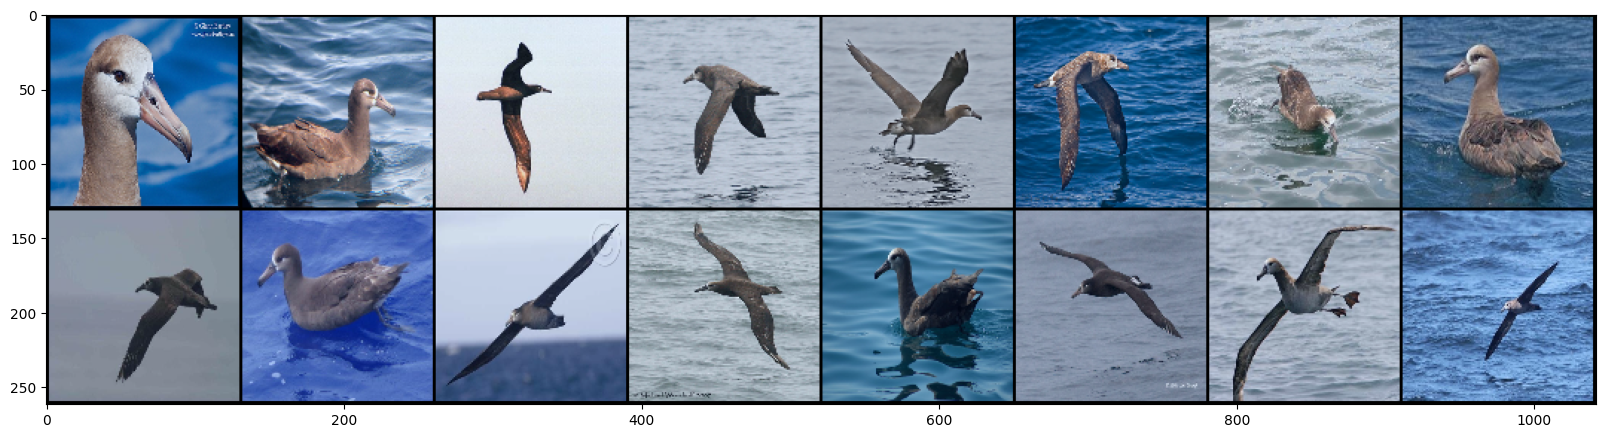

In [63]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(images[0:16], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Show ground Truth

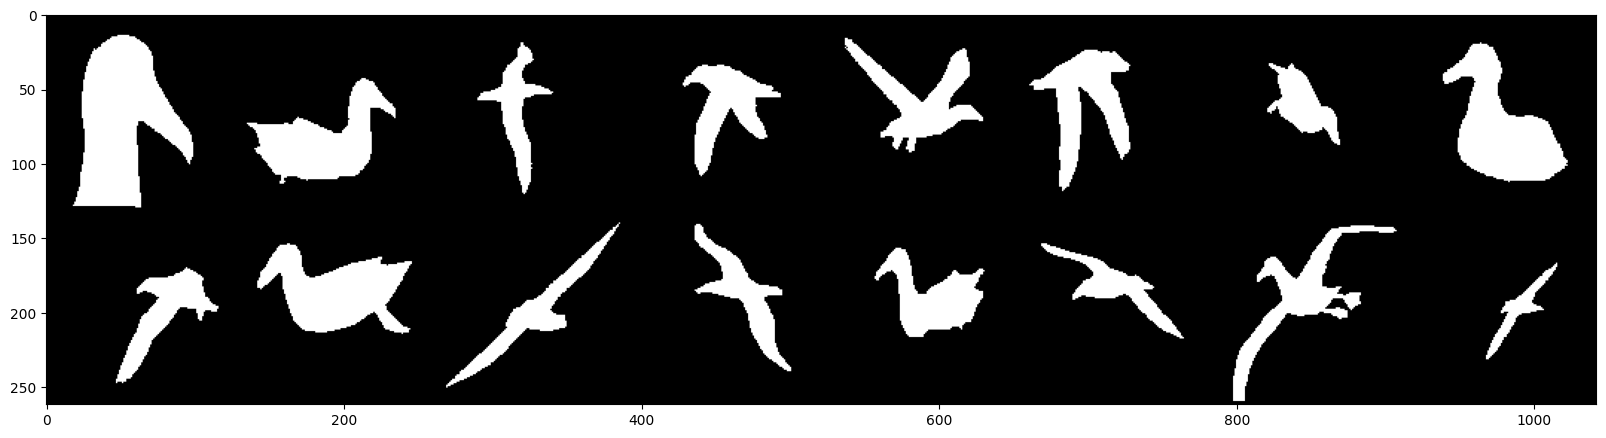

In [64]:
plt.figure(figsize = (20,10))
out = vutils.make_grid((mask[0:16]).unsqueeze(1).float(), normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Make the Predictions

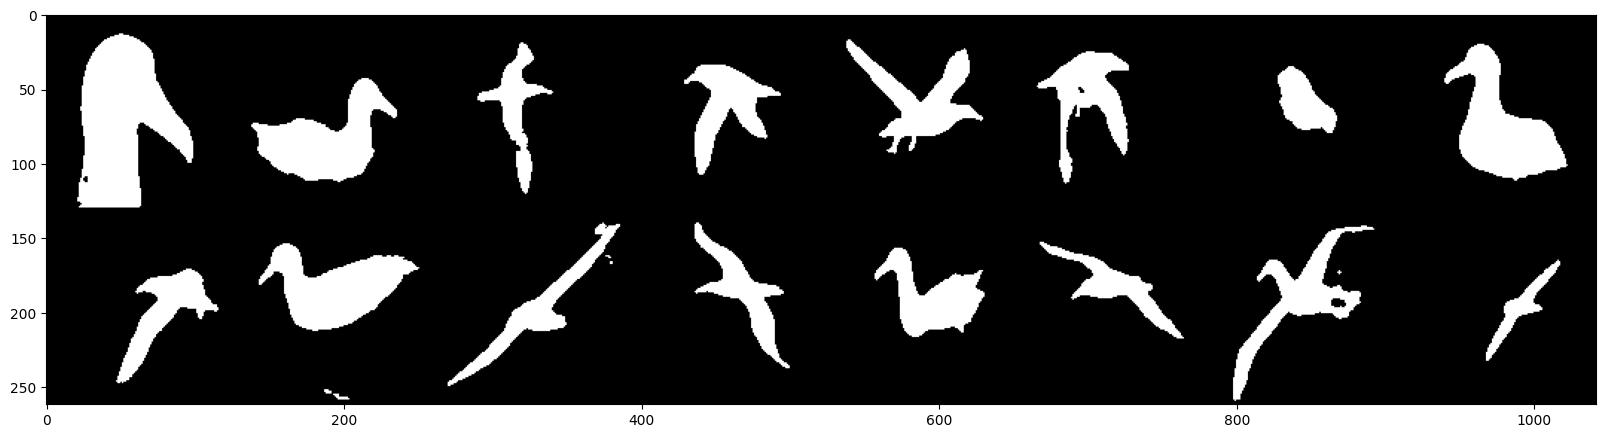

In [65]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(pred_out[0:16].unsqueeze(1).float(), normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

### Test Data Evaluation

In [66]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = evaluate_model(train_test_val="test")
print("The Test Average IoU is: %.2f" %(test_acc))

Evaluating Test Set:   0%|          | 0/57 [00:00<?, ?it/s]

The Test Average IoU is: 0.82


## Optimization and Tuning

Fine-tuning and optimizing a U-Net model, involves a series of steps and considerations aimed at enhancing the model's performance, particularly in tasks like image segmentation. Here are some tips to help you achieve better results:

### 1. Data Preprocessing
- **Augmentation**: Increase the data augmentation techniques (e.g., rotation, flipping, scaling) to increase the diversity of your training data, improving the model's robustness and ability to generalize.

### 2. Model Architecture Adjustments
- **Depth and Width**: Experiment with the depth (number of layers) and width (number of channels) of your U-Net model. Increasing them can improve the model's capacity but also requires more data and computational resources.

### 3. Training Strategies
- **Learning Rate Scheduling**: Try differen learning rate scheduling (e.g., ReduceLROnPlateau, CosineAnnealingLR) to adjust the learning rate during training dynamically, potentially leading to better convergence.

- **Gradient Accumulation**: For training with high-resolution images on limited GPU memory, gradient accumulation allows you to use larger batch sizes effectively by dividing them into smaller sub-batches.

### 4. Loss Functions and Metrics
- **Custom Loss Functions**: Beyond the standard cross-entropy loss, consider using custom or advanced loss functions that are more aligned with your specific task, such as Dice loss or a combination of Dice and cross-entropy losses, for segmentation tasks.

### 5. Post-processing Techniques
- **Ensemble Models**: Combine the predictions of multiple models or multiple runs of the same model to improve the overall performance and stability of your predictions.

### 6. Use Pretrained Models
- **Transfer Learning**: Start with a model pretrained on a large dataset (e.g., ImageNet) and fine-tune it on your specific dataset. This approach can lead to faster convergence and improved model performance, especially when you have a limited amount of labeled data.

### 7. Optimization and Hardware Utilization
- **Mixed Precision Training**: Utilize mixed precision training to speed up computations and reduce memory usage without significantly impacting the model's performance.
- **Distributed Training**: For very large datasets or models, consider distributed training across multiple GPUs to accelerate the training process.

Fine-tuning and optimizing a model is an iterative process that involves experimentation and adjustment based on the specific characteristics of your dataset and task. Monitoring and evaluating the model's performance continuously during the training process is crucial to identify the most effective strategies.

# References

- Types of image segmentation image: https://mindy-support.com/news-post/what-is-image-segmentation-the-basics-and-key-techniques/

- Image segmentation vs. object detection vs. image classification vs. localization image: Jaiswal, A., Babu, A. R., Zadeh, M. Z., Banerjee, D., &
Makedon, F. (2021). A survey on contrastive self-supervised learning Technologies: https://www.mdpi.com/2227-7080/9/1/2